In [1]:
import requests
from IPython.display import Markdown

url = 'https://kata.geosci.ai/challenge/prospecting'

r = requests.get(url)
print('Status', r.status_code)

Markdown(r.text)

Status 200


# Prospecting

We have 5 arrays of 4096 elements each. Each array represents a map as a 'raster' with 64 &times; 64 = 4096 pixels, and is given as a row in the dataset. Each pixel is represented by a single integer, taking values from 0 to 8.

The maps represent different things. In order, they are:

1. Reliability of well data.
2. Reliability of seismic data.
3. Porosity from wells and conceptual models.
4. Fracture density from wells and seismic.
5. Our land position (1 denotes 'our land').

We need to answer the following questions:

1. How many pixels have zero total reliability?
2. How many pixels are predicted to have better than 50th percentile (P50) porosity and better than P50 fracture density?
3. How many of these pixels have non-zero reliability and are on our land? These blobs are our _prospects_.
4. Find the product of the (x, y) coordinates of the cell containing the centre of mass of the largest _prospect_ blob.

For question 4, a centre of mass at (3.4, 12.6) is in the cell (3, 12) and you would respond with 3 &times; 12 = **36**.

We'll consider blobs to be connected if they have directly neighbouring pixels. In example A, below, there are 3 'blobs' of one pixel each. In example B there are 2 blobs, each with three pixels.

      A        B
    1 0 1    1 1 0
    0 1 0    1 0 1
    0 0 0    0 1 1


## Example

Here is a dataset of smaller maps. Every row represents a map, each 3 &times 3 pixels:

    example = """0,1,0,1,2,1,0,1,0
                 2,1,0,1,1,1,0,1,0
                 0,1,2,1,3,1,1,2,2
                 0,2,1,2,3,1,1,3,2
                 1,1,1,1,1,1,0,0,0"""

If we re-shaped each row to make a 3 &times; 3 map, the maps would look like:

      1       2       3       4       5    <--- map number
    0 1 0   2 1 0   0 1 2   0 2 1   1 1 1
    1 2 1   1 1 1   1 3 1   2 3 1   1 1 1
    0 1 0   0 1 0   1 2 2   1 3 2   0 0 0   

Here's how we might answer the questions:

1. There are **3** pixels with zeros in both of the reliability maps (the first two maps).
1. The P50 values on maps 3 and 4 are 1 and 2 respectively. There are **2** pixels that are higher on both maps.
1. Of those pixels, **1** has non-zero reliability and is on our land (map 5).
1. The coordinates of that pixels are (1, 1) so the product of those coordinates is **1**.


## Hints

It's likely that the `scipy.ndimage.measurements` module will be useful in answering question 4. For example, if you have an array `arr` like:

    0 1 1
    0 0 0
    1 0 0

Then `scipy.ndimage.measurements.label()` will return two things: the labels and the number 2 (meaning it found 2 objects). The labels have the same shape as the original 'map':

    0 1 1   <--- 1 denotes 'object 1'
    0 0 0   <--- 0 denotes 'background', i.e. no objects
    2 0 0   <--- 2 denotes 'object 2'

Once you have labels, you can get the centre of mass of the object labelled `3` with `scipy.ndimage.measurements.center_of_mass(arr, labels, 3)`.

We will use the default behaviour of the `scipy.ndimage.measurements.label()` function to decide if things are separate objects.


## A quick reminder how this works

You can retrieve your data by choosing any Python string as a **`<KEY>`** and substituting here:
    
    https://kata.geosci.ai/challenge/prospecting?key=<KEY>
                                                     ^^^^^
                                                     use your own string here

To answer question 1, make a request like:

    https://kata.geosci.ai/challenge/prospecting?key=<KEY>&question=1&answer=1234
                                                     ^^^^^          ^        ^^^^
                                                     your key       Q        your answer

[Complete instructions at kata.geosci.ai](https://kata.geosci.ai/challenge)

----

© 2020 Agile Scientific, licensed CC-BY

## Load the input data

In [12]:
my_key = "scibbatical"

params = {'key': my_key}

r = requests.get(url, params)

# Look at the first bit of the input:
r.text[:100]

'0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,'

### Parse the data

Okay, the problem states that each input map is one row of the input, and that each map has 64x64 pixels (=4096). Let's look for the first '\n', but remember that each comma also contributes to the string length :

In [16]:
r.text[8190:8220]

'0\n0,0,0,0,0,1,1,2,2,2,3,3,4,4,'

There it is! Okay, now that we've verified that the '\n' characters are used, let's split things up:

In [24]:
textmaps = r.text.split('\n')

print(len(textmaps), 'maps')
print(len(textmaps[0]), 'characters per map')
print(len(maps[0].split(',')),'digits per map')

5 maps
8191 characters per map
4096 digits per map


Okay! This is working. Now we need to transform the strings into numpy arrays.

In [37]:
import numpy as np

well_reliability = eval('np.array([' + textmaps[0] +'])').reshape(64,64)
seis_reliability = eval('np.array([' + textmaps[1] +'])').reshape(64,64)
poro = eval('np.array([' + textmaps[2] +'])').reshape(64,64)
frac = eval('np.array([' + textmaps[3] +'])').reshape(64,64)
land = eval('np.array([' + textmaps[4] +'])').reshape(64,64)

## Question 1

_How many pixels have zero total reliability?_

I'm going to take this to mean that they have zero seismic and zero well reliability. This can be determined by adding these maps. Cells that still have zero value will have zero total reliability!

In [44]:
total_reliability = well_reliability + seis_reliability

reliability_zeros = 4096 - np.count_nonzero(total_reliability)

print('There are', reliability_zeros, 'pixels with zero reliability')

There are 301 pixels with zero reliability


Submit answer 1:

In [45]:
params = {'key': my_key,   # <--- must be the same key as before
          'question': 1,   # <--- which question you're answering
          'answer': reliability_zeros,  # <--- your answer to that question
         }

r = requests.get(url, params)

r.text

'Correct'

Yeah!

## Question 2

_How many pixels are predicted to have better than 50th percentile (P50) porosity and better than P50 fracture density?_

Okay, first I need to calculate the P50 for poro and frac.

In [46]:
poro_p50 = np.percentile(poro, 50)
frac_p50 = np.percentile(frac, 50)

print('P50 for porosity is', poro_p50)
print('P50 for fracture density is', frac_p50)

P50 for porosity is 3.0
P50 for fracture density is 3.0


Okay, now find the number of cells in each map that are greater than the p50 values, then add those maps together. Count the number of times the values of the combined maps are two:

In [62]:
# Create the maps where values are larger than P50
poro_p50_flag = np.where(poro > poro_p50, np.ones_like(poro),np.zeros_like(poro))
frac_p50_flag = np.where(frac > frac_p50, np.ones_like(frac),np.zeros_like(frac))

# Combine the maps. 0 is no P50, 1 is one attribute > P50, 2 is both attributes > P50
p50s_map = poro_p50_flag + frac_p50_flag

# Count the number of cells with value 2:
p50s_cell_count = len(np.where(p50s_map == 2)[0])

print(p50s_cell_count, 'cells where porosity and fracture density are greater than their respective P50 values.')

779 cells where porosity and fracture density are greater than their respective P50 values.


Submit answer 2:

In [64]:
params = {'key': my_key,   # <--- must be the same key as before
          'question': 2,   # <--- which question you're answering
          'answer': p50s_cell_count,  # <--- your answer to that question
         }

r = requests.get(url, params)

r.text

'Correct'

## Question 3

_How many of these pixels have non-zero reliability and are on our land? These blobs are our prospects._

Okay, we're combining all the maps now. Make sure we have each map as a flag map and then add them up!

In [74]:
# Data reliability:
reliability_flag = np.where(total_reliability > 0,
                            np.ones_like(total_reliability),
                            np.zeros_like(total_reliability))

# Porosity and Fracture Density flag maps already exist...

# Land map is already a binary flag!

# Add these maps to create a prospectivity map:
prospectivity = reliability_flag + poro_p50_flag + frac_p50_flag + land

# And then transform the prospectivity map into a prospect flag map:
prospect_flag = np.where(prospectivity == 4,
                         np.ones_like(prospect_flag), np.zeros_like(prospect_flag))

# Now count the cells that are flagged:
prospect_cell_count = len(np.where(prospect_flag == 1)[0])

print(prospect_cell_count, 'cells are prospects.')

430 cells are prospects.


Submit answer 3:

In [75]:
params = {'key': my_key,   # <--- must be the same key as before
          'question': 3,   # <--- which question you're answering
          'answer': prospect_cell_count,  # <--- your answer to that question
         }

r = requests.get(url, params)

r.text

'Correct'

## Question 4:

_Find the product of the (x, y) coordinates of the cell containing the centre of mass of the largest prospect blob._

Now, this might be tricky, so Agile provides a hint:

_It's likely that the scipy.ndimage.measurements module will be useful in answering question 4._

_Then scipy.ndimage.measurements.label() will return two things: the labels and the number 2 (meaning it found 2 objects)._

Once you have labels, you can get the centre of mass of the object labelled 3 with scipy.ndimage.measurements.center_of_mass(arr, labels, 3).

Okay then...

In [77]:
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

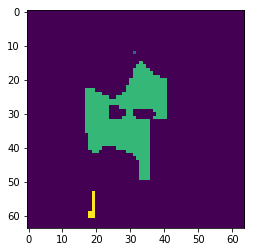

In [86]:
plt.imshow(ndi.measurements.label(prospect_flag)[0])

I see three prospects. The largest one appears to be number 2.

In [94]:
prospect2_com = ndi.measurements.center_of_mass(prospect_flag,
                                                ndi.measurements.label(prospect_flag)[0], 2 )


prospect2_com

(30.801909307875896, 28.87112171837709)

Now, "which cell contains the center of mass"? I think we need to round these floats down to the integer values.

In [102]:
prospect2_com_int = np.array([prospect2_com]).astype(int)

answer4 = np.prod(prospect2_com_int)

print('The product of the center of mass cells is', answer4)

The product of the center of mass cells is 840


Submit answer 4:

In [103]:
params = {'key': my_key,   # <--- must be the same key as before
          'question': 4,   # <--- which question you're answering
          'answer': answer4,  # <--- your answer to that question
         }

r = requests.get(url, params)

r.text

'Correct! The next challenge is: https://kata.geosci.ai/challenge/birthquakes - good luck!'